In [ ]:
# Import necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
# GPU check
import psutil
import humanize
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Helper function for displaying images and labels
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
# Get the dataset
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

--2022-07-21 17:47:49--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  13.3MB/s    in 44s     

2022-07-21 17:48:34 (12.5 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
# Remove existing directories
!rm -r Cat_Dog_data __MACOSX || true
!unzip -qq Cat_Dog_data.zip

rm: cannot remove 'Cat_Dog_data': No such file or directory
rm: cannot remove '__MACOSX': No such file or directory


In [ ]:
# Loading the cats and dogs dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

data_dir = "Cat_Dog_data"

# Define transforms for the training and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Pass transforms here
train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)

In [ ]:
# Examine a sample
data_iter = iter(trainloader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


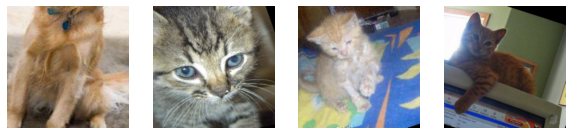

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), ncols = 4)
for ii in range(4):
  ax = axes[ii]
  imshow(images[ii], ax = ax, normalize=False)

In [ ]:
# Load the pre-trained model
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze feature parameters
for param in model.parameters():
  param.requires_grad = False
  
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Training the model with feed forward network
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
model.cuda()

# Define epochs
epochs = 1

# Define optimizer
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)

# Define loss
criterion = nn.NLLLoss()

# Define running loss
running_loss = 0

# Define steps
step = 0
print_every = 5

for epoch in range(epochs):
  for inputs, labels in trainloader:
    step += 1
    
    # Shift computation to GPU
    inputs, labels = inputs.cuda(), labels.cuda()
  
    # Training pass
    optimizer.zero_grad()
  
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  
    running_loss += loss.item()
    
    if step % print_every == 0:
      model.eval()
      test_loss = 0
      accuracy = 0
      
      for inputs, labels in testloader:
        # Shift computation to GPU
        inputs, labels = inputs.cuda(), labels.cuda()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_ps, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
      print("Epoch: {}/{}..".format(epoch+1, epochs),
          "Training loss: {:.8f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.8f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.8f}".format(accuracy/len(testloader)))
      
      running_loss = 0
      model.train()

Epoch: 1/1.. Training loss: 0.01130292.. Test loss: 0.82327466.. Test Accuracy: 0.68037975
Epoch: 1/1.. Training loss: 0.01058003.. Test loss: 0.33745986.. Test Accuracy: 0.84889241
Epoch: 1/1.. Training loss: 0.00463394.. Test loss: 0.10508612.. Test Accuracy: 0.95965190
Epoch: 1/1.. Training loss: 0.00426046.. Test loss: 0.46609607.. Test Accuracy: 0.80498418
Epoch: 1/1.. Training loss: 0.00180229.. Test loss: 0.16423760.. Test Accuracy: 0.93077532
Epoch: 1/1.. Training loss: 0.00224913.. Test loss: 0.07952823.. Test Accuracy: 0.97231013
Epoch: 1/1.. Training loss: 0.00166719.. Test loss: 0.12796371.. Test Accuracy: 0.95015823
Epoch: 1/1.. Training loss: 0.00098463.. Test loss: 0.09240343.. Test Accuracy: 0.96360759
Epoch: 1/1.. Training loss: 0.00230612.. Test loss: 0.12113702.. Test Accuracy: 0.95253165
Epoch: 1/1.. Training loss: 0.00112530.. Test loss: 0.08483345.. Test Accuracy: 0.96439873
Epoch: 1/1.. Training loss: 0.00121438.. Test loss: 0.06818446.. Test Accuracy: 0.97428797

In [16]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

In [17]:
torch.save(checkpoint, './catvdog.pth')

In [18]:
# Helper function view_classify to classify images into cats and dogs
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(['Cat', 'Dog'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

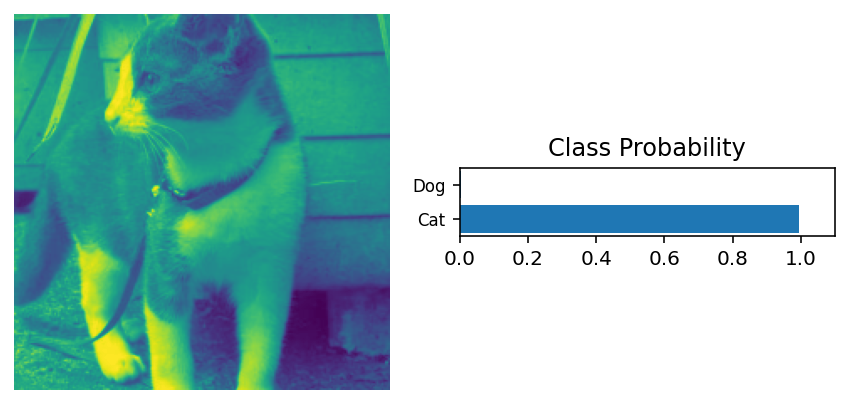

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing out the network
dataiter = iter(testloader)
images, labels = dataiter.next()

# Bring the model and test sample to CPU
model.cpu()
images, labels = images.cpu(), labels.cpu()

# Calculate the class probabilites (log softmax) for images
ps = torch.exp(model(images))

# Plot the image and probabilites
view_classify(images[0], ps[0])